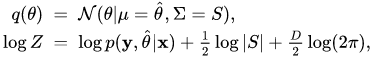

### **Least squares evidence**
Differentiate cost wrt parameters. Don't forget to divide through by $2\sigma^2$ at the end

General Gaussian error
$$ P(\{y_i\}|\theta, M) = \prod_i \frac{1}{\sqrt{2\pi}\sigma_i} \exp \left[- \frac{|y_i - f(x_i, \theta)|^2}{2\sigma_i^2}\right] $$

Our specific case
$$ \log P(\{X_i\}|\theta, \sigma) = - \frac{1}{2}N\log 2\pi - N\log\sigma - \frac{1}{2\sigma^2}\sum |\mathrm{E}[X_i] - g(\log L_i, \theta)|^2 $$ 
$$ = - \frac{1}{2}N\log (2\pi \sigma^2) - \frac{1}{2\sigma^2}\sum |\mathrm{E}[X_i] - g(\log L_i, \theta)|^2
$$
Call $ L(\theta)^2 = \sum |\mathrm{E}[X_i] - g(\log L_i, \theta)|^2 $. Maximising $\log P$ means separate maximisation of $L$ wrt $\theta$, and the result wrt $\sigma$. N is the number of data points

$$ \log P = \mathrm{const} - N\log\sigma - \frac{L^2}{2\sigma^2}$$
$$ \hat{\sigma}^2 = \frac{L^2}{N}$$


Evidence; $\Sigma = -H^{-1}$, $\log|\Sigma| = - \log|H|$ 

<!-- $$ \log Z = \log P_\mathrm{max} + \frac{1}{2} \log |\Sigma| + \frac{D}{2} \log 2\pi $$ -->
$$ \log Z = \log P_\mathrm{max} - \frac{1}{2} \log |H| + \frac{D}{2} \log 2\pi $$





In [24]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)
from scipy.optimize import minimize, least_squares

# Load test samples
from aeons.tools import pickle_in
samples_g_1, samples_c_1, samples_w_1 = pickle_in("../test_samples/samples_1.pickle")

from aeons.covariance import logX_mu, logX_Sigmainv, points_at_iteration, X_mu, X_Sigma, X_Sigmainv, data_at_iteration
from aeons.true_distribution import generate_Xs
from aeons.lm_partial import analytic_lm_params
from aeons.bayes import logPr_bayes, logPr_laplace, logPr_gaussian, minimise_ls, minimise_bayes, minimise_gaussian
from aeons.likelihoods import likelihood, linear_like, quad_like, log_like, simple_like, middle_like, full_like
linear, quad, log = linear_like(), quad_like(), log_like()
simple, middle, full = simple_like(), middle_like(), full_like()
simple_log, middle_log, full_log = simple_like(logX=True), middle_like(logX=True), full_like(logX=True)
from aeons.hessian import hess_autograd

### **Implementation of least squares Hessian + checks**

In [25]:
def sigma_est(y, likelihood, mean_X, theta):
    N = len(y)
    loss = mean_X - likelihood.inverse(y, theta)
    return np.sqrt(np.sum(loss**2)/N)

def logPr_ls(y, likelihood, mean_X, theta):
    N = len(y)
    loss = mean_X - likelihood.inverse(y, theta)
    L_sq = np.sum(loss**2)
    sigma = np.sqrt(L_sq/N)
    prefactor = -1/2 * N * np.log(2*np.pi*sigma**2)
    return prefactor - L_sq/(2*sigma**2)

def hess_ls_sigma(y, likelihood, mean_X, theta_max, sigma):
    N = len(y)
    y = torch.from_numpy(y)
    mean_X = torch.from_numpy(mean_X)
    theta_sigma_max = torch.tensor([*theta_max, sigma], requires_grad=True)
    def func(theta_sigma):
        *theta, sigma = theta_sigma
        loss = mean_X - likelihood.inverse(y, theta)
        L_sq = torch.sum(loss**2)
        prefactor = -1/2 * N * torch.log(2*np.pi*sigma**2)
        return prefactor - L_sq/(2*sigma**2)
    from torch.autograd.functional import hessian
    H = hessian(func, theta_sigma_max)
    return np.array(H)

In [26]:
points = 1000
nk = 500 * np.ones(points)
mean_X = X_mu(nk)
theta_true = [5, 10, 0.1]
X = generate_Xs(nk)
y = full.func(X, theta_true)

In [27]:
theta_l = minimise_ls(y, full, mean_X, theta_true).x
sigma_l = sigma_est(y, full, mean_X, theta_l)
H_sigma = hess_ls_sigma(y, full, mean_X, theta_l, sigma_l)
logPmax = logPr_ls(y, full, mean_X, theta_l)

In [28]:
def check_hess(theta_max, param, lim=1e-2):
    dict = {"logLmax": 0, "d": 1, "sigma": 2}
    param_index = dict.get(param)
    param_max = theta_max[param_index]
    params = np.linspace(param_max*(1-lim), param_max*(1+lim), 1000)
    logprs_ls = np.zeros_like(params)
    logprs_laplace = np.zeros_like(params)
    for i, param in enumerate(params):
        theta_arr = np.copy(theta_max)
        theta_arr[param_index] = param
        logprs_ls[i] = logPr_ls(y, full, mean_X, theta_arr)
        logprs_laplace[i] = logPr_laplace(param, logPmax, param_max, H_sigma[param_index][param_index])
    return params, logprs_ls, logprs_laplace

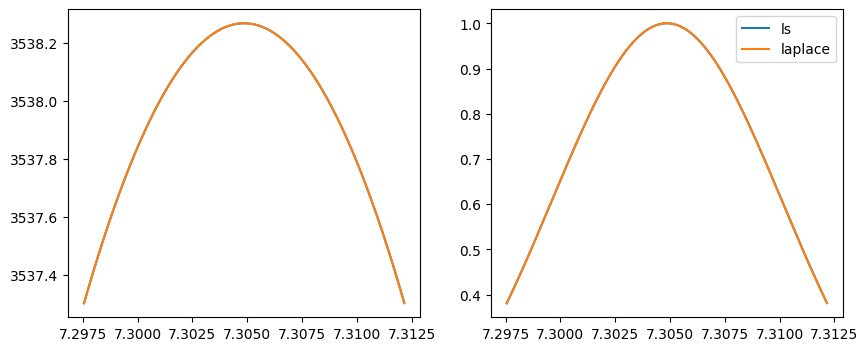

In [29]:
params, logprs_ls, logprs_laplace = check_hess(theta_l, 'd', lim=1e-3)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))
ax1.plot(params, logprs_ls, label='ls')
ax1.plot(params, logprs_laplace, label='laplace')
ax2.plot(params, np.exp(logprs_ls - logprs_ls.max()), label='ls')
ax2.plot(params, np.exp(logprs_laplace - logprs_laplace.max()), label='laplace')
plt.legend()

### **How predictive is $\bm{Z}$?**

In [30]:
def logZ(logPmax, H, D):
    return logPmax - 1/2 * np.log(abs(np.linalg.det(H))) + D/2 * np.log(2*np.pi)

def X_end(d, sigma):
    """Returns end value of X given estimates of d, sigma"""
    from scipy.special import gamma
    return gamma(1+d/2) * 2**(d/2) * sigma**d

In [31]:
def nk_dead(nlive, ndead):
    return nlive * np.ones(ndead)

def nk_dead_live(nlive, ndead):
    nk0 = nlive * np.ones(ndead)
    nk1 = np.flip(np.arange(1, nlive))
    return np.concatenate((nk0, nk1))

def nk_live(nlive):
    return np.flip(np.arange(1, nlive + 1))

def minimise_ls_y(logL, likelihood, mean, theta0, bounds=(-np.inf, np.inf)):
    def loss(theta):
        return logL - likelihood.func(mean, theta)
    solution = least_squares(loss, theta0, bounds=bounds)
    return solution

In [32]:
# nk = 500 * np.ones(1000)
# nk = nk_live(500)
nk = nk_dead_live(500, 1000)
mean_X = X_mu(nk)
covinv_X = X_Sigmainv(nk)
# covinv_X = X_Sigmainv(nk)

(array([0.97608733, 9.82452872, 0.09907426]),
 array([1.63128837e-04, 9.53388364e+00, 9.99793706e-02]))

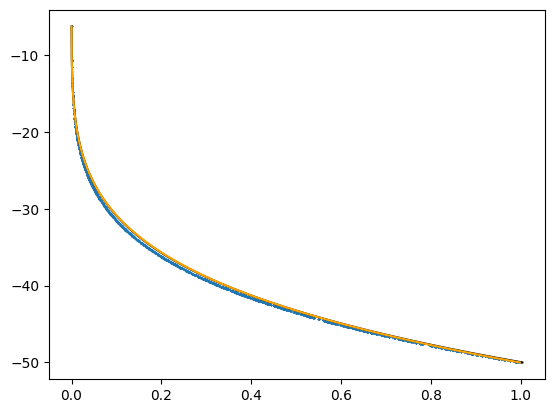

In [33]:
X = generate_Xs(nk)
theta_true = [0, 10, 0.1]
y = full.func(X, theta_true)
theta_l = minimise_ls(y, full, mean_X, theta_true).x
theta_b = minimise_bayes(y, full, mean_X, covinv_X, theta_true).x
plt.plot(X, y, 'x', ms=1)
plt.plot(full.inverse(y, theta_l), y, color='black')
plt.plot(full.inverse(y, theta_b), y, color='orange')
theta_l, theta_b